# Análise de partidas de League of Legends
Dados obtidos em https://www.kaggle.com/datasets/datasnaek/league-of-legends

## Análise dos dados

Partidas de League of Legends são jogados por 2 times de 5 pessoas.

Os personagens jogados são selecionados alternadamente.

O time 1, ou time azul, joga na parte inferior do mapa e começa selecionando os personagens.

O time 2, ou time vermelho, joga na parte superior do mapa e tem a última seleção.

### Importando libs do spark

In [1]:
import seaborn as sns
from itertools import islice
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import avg,col,when,count,lit
from pyspark.sql.types import *


### Criando SparkSession local

In [2]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

### Carregando o dataset no Spark

In [3]:
table = spark.read.csv("data/games.csv",
                       header=True,
                       inferSchema=True).persist()

### Schema do dataset

In [4]:
table.printSchema()

root
 |-- gameId: long (nullable = true)
 |-- creationTime: long (nullable = true)
 |-- gameDuration: integer (nullable = true)
 |-- seasonId: integer (nullable = true)
 |-- winner: integer (nullable = true)
 |-- firstBlood: integer (nullable = true)
 |-- firstTower: integer (nullable = true)
 |-- firstInhibitor: integer (nullable = true)
 |-- firstBaron: integer (nullable = true)
 |-- firstDragon: integer (nullable = true)
 |-- firstRiftHerald: integer (nullable = true)
 |-- t1_champ1id: integer (nullable = true)
 |-- t1_champ1_sum1: integer (nullable = true)
 |-- t1_champ1_sum2: integer (nullable = true)
 |-- t1_champ2id: integer (nullable = true)
 |-- t1_champ2_sum1: integer (nullable = true)
 |-- t1_champ2_sum2: integer (nullable = true)
 |-- t1_champ3id: integer (nullable = true)
 |-- t1_champ3_sum1: integer (nullable = true)
 |-- t1_champ3_sum2: integer (nullable = true)
 |-- t1_champ4id: integer (nullable = true)
 |-- t1_champ4_sum1: integer (nullable = true)
 |-- t1_champ4_sum2

### Alguns dados do dataset

In [5]:
table.show()

+----------+-------------+------------+--------+------+----------+----------+--------------+----------+-----------+---------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+
|    gameId| creationTime|gameDuration|seasonId|winner|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|t1_champ1id|t1_champ1_sum1|t1_champ1_sum2|t1_champ2id|t1_champ2_sum1|t1_champ

### Dados faltantes

In [6]:
table.select([count(when(col(c)==0, c)).alias(c) for c in table.columns]).show()

+------+------------+------------+--------+------+----------+----------+--------------+----------+-----------+---------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+
|gameId|creationTime|gameDuration|seasonId|winner|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|t1_champ1id|t1_champ1_sum1|t1_champ1_sum2|t1_champ2id|t1_champ2_sum1|t1_champ2_sum2|t1_

### Removendo linhas com dados faltantes
Como o time azul é o time 1 e o time vermelho é o time 2, dados com valor 0 não representam a neutralidade que deveriam.

Para corrigir isso, vamos substituir os valores 2 por -1. Assim não precisaremos ajustar os valores zerados e eles indicaram uma neutralidade.

In [7]:
replaceColumns = ["winner","firstBlood","firstTower","firstInhibitor","firstBaron","firstDragon","firstRiftHerald"]

for column in replaceColumns:
        table = table.withColumn(column, when(col(column)==2,lit(-1)).otherwise(col(column)))

### Colunas de interesse para analisar as taxas de vitória

In [8]:
columns = list(filter(lambda x: x not in ["gameId", "creationTime", "seasonId", "winner"], table.columns))
print(columns)

['gameDuration', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id', 't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']


### Correlação entre os principais parâmetros e a taxa de vitória
Números negativos significa parâmetro benéfico ao time 1, números positivos significa parâmetro benéfico ao time 2

As colunas firstBlood, firstTower, firstInhibitor, firstBaron, firstDragon, firstRiftHerald tem o número do time que conseguiu o objetivo, então essas relações indicam o nível de importância do objetivo para a vitória, independente do lado jogado.

In [9]:
cor={}
for column in columns:
    cor[column]= table.stat.corr(column, "winner")

print("{:<20} {:<15}".format('Column','Winner'))
for k, v in cor.items():
    print("{:<20} {:<15}".format(k, round(v,2)))

Column               Winner         
gameDuration         -0.02          
firstBlood           0.18           
firstTower           0.41           
firstInhibitor       0.77           
firstBaron           0.48           
firstDragon          0.35           
firstRiftHerald      0.27           
t1_champ1id          -0.02          
t1_champ1_sum1       -0.0           
t1_champ1_sum2       0.0            
t1_champ2id          -0.02          
t1_champ2_sum1       -0.0           
t1_champ2_sum2       0.0            
t1_champ3id          -0.02          
t1_champ3_sum1       0.0            
t1_champ3_sum2       0.0            
t1_champ4id          -0.02          
t1_champ4_sum1       0.0            
t1_champ4_sum2       0.0            
t1_champ5id          -0.03          
t1_champ5_sum1       0.0            
t1_champ5_sum2       0.0            
t1_towerKills        0.77           
t1_inhibitorKills    0.65           
t1_baronKills        0.37           
t1_dragonKills       0.47           
t

### Convertendo para o pandas para poder usar bibliotecas gráficas

In [10]:
pandasTable = table.toPandas()

### Relação entre tempo de partida e time vencedor

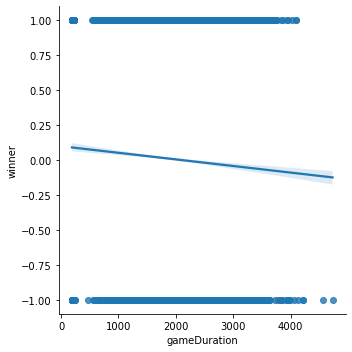

In [11]:
sns.lmplot(x='gameDuration',y='winner',data=pandasTable,fit_reg=True)

### Relação com o first blood

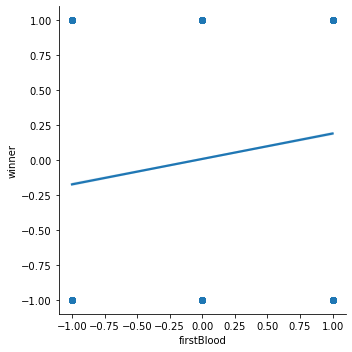

In [12]:
sns.lmplot(x='firstBlood',y='winner',data=pandasTable,fit_reg=True)

### Relação com a primeira torre derrubada

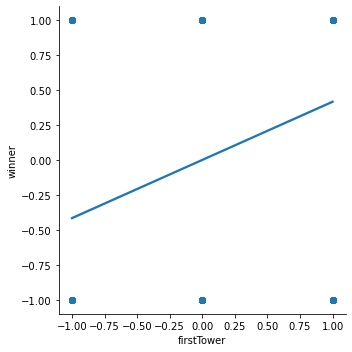

In [13]:
sns.lmplot(x='firstTower',y='winner',data=pandasTable,fit_reg=True)

### Relação com o primeiro inibidor derrubado         

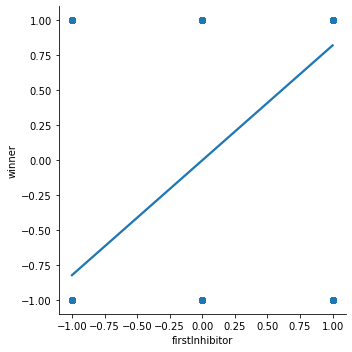

In [14]:
sns.lmplot(x='firstInhibitor',y='winner',data=pandasTable,fit_reg=True)

### Relação com o primeiro barão

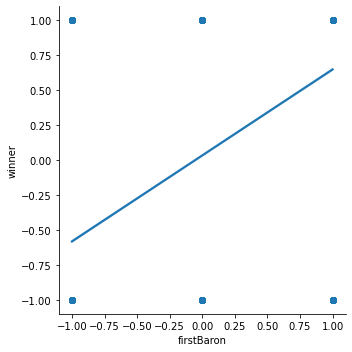

In [15]:
sns.lmplot(x='firstBaron',y='winner',data=pandasTable,fit_reg=True)

### Relação com o primeiro dragão

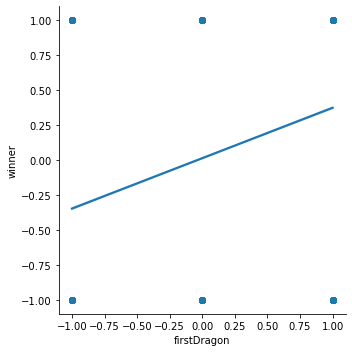

In [16]:
sns.lmplot(x='firstDragon',y='winner',data=pandasTable,fit_reg=True)

### Relação com o primeiro arauto

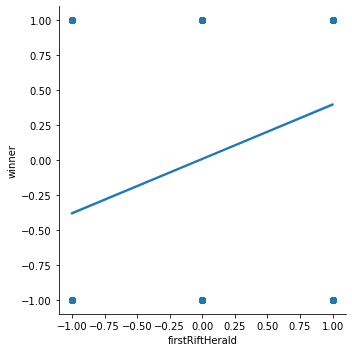

In [17]:
sns.lmplot(x='firstRiftHerald',y='winner',data=pandasTable,fit_reg=True)   

## Preparação de um algoritmo de RandomForest para prever o vencedor

### Separando em dados de teste e treino

In [19]:
(dataTrain, dataTest) = table.randomSplit((0.8, 0.2))

### Dados de treino

In [20]:
dataTrain.show()

+----------+-------------+------------+--------+------+----------+----------+--------------+----------+-----------+---------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+
|    gameId| creationTime|gameDuration|seasonId|winner|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|t1_champ1id|t1_champ1_sum1|t1_champ1_sum2|t1_champ2id|t1_champ2_sum1|t1_champ

### Dados de teste

In [21]:
dataTest.show()

+----------+-------------+------------+--------+------+----------+----------+--------------+----------+-----------+---------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+
|    gameId| creationTime|gameDuration|seasonId|winner|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|t1_champ1id|t1_champ1_sum1|t1_champ1_sum2|t1_champ2id|t1_champ2_sum1|t1_champ

### Cálculo utilizando todos os dados obtidos após o fim da partida

In [22]:
assembler = VectorAssembler(
    inputCols=columns,
    outputCol="features"
)

indexer = StringIndexer(
    inputCol="winner",
    outputCol="label"
)

randomForestClassifier = RandomForestClassifier(
    impurity="gini",
    maxDepth=3,
    numTrees=20,
    featureSubsetStrategy="auto"
)

stages = (assembler, indexer, randomForestClassifier)

pipeline = Pipeline(stages=stages)

evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    metricName="areaUnderROC"
)

paramGrid = ParamGridBuilder().addGrid(
    randomForestClassifier.maxBins, [25, 28, 31]
).addGrid(
    randomForestClassifier.maxDepth, [4, 6, 8]
).addGrid(
    randomForestClassifier.impurity, ["entropy", "gini"]
).build()

cv = CrossValidator(
    estimator=pipeline,
    evaluator=evaluator,
    estimatorParamMaps=paramGrid,
    numFolds=5
)

cvModel = cv.fit(dataTrain)

cvPredictionDf = cvModel.transform(dataTest)
cvPredictionDf.show()

+----------+-------------+------------+--------+------+----------+----------+--------------+----------+-----------+---------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+--------------------+-----+--------------------+--------------------+----------+
|    gameId| creationTime|gameDuration|seasonId|winner|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHera

### Avaliando modelo

In [23]:
accPos = evaluator.evaluate(cvPredictionDf)
accPos

0.9961946098362215

In [24]:
# salvar o modelo no diretorio
# cvModel.write().overwrite().save("data/model/lol")
# carregar o modelo do diretorio
# cvModelLoaded = CrossValidatorModel.load("data/model/lol")

### Cálculo utilizando os dados da seleção de campeões, para tentar prever o vencedor após a preparação e antes da partida

In [28]:
columnsPre = list(filter(lambda x: x not in ["gameId", 
                                             "creationTime",
                                             "seasonId",
                                             "winner",
                                             "gameDuration",
                                             "firstBlood",
                                             "firstTower",
                                             "firstInhibitor",
                                             "firstBaron",
                                             "firstDragon",
                                             "firstRiftHerald",
                                             "t1_towerKills",
                                             "t1_inhibitorKills",
                                             "t1_baronKills",
                                             "t1_dragonKills",
                                             "t1_riftHeraldKills",
                                             "t2_towerKills",
                                             "t2_inhibitorKills",
                                             "t2_baronKills",
                                             "t2_dragonKills",
                                             "t2_riftHeraldKills"],table.columns))

assemblerPre = VectorAssembler(
    inputCols=columnsPre,
    outputCol="features"
)

indexerPre = StringIndexer(
    inputCol="winner",
    outputCol="label"
)

randomForestClassifierPre = RandomForestClassifier(
    impurity="gini",
    maxDepth=3,
    numTrees=20,
    featureSubsetStrategy="auto"
)

stagesPre = (assemblerPre, indexerPre, randomForestClassifierPre)

pipelinePre = Pipeline(stages=stagesPre)

evaluatorPre = BinaryClassificationEvaluator(
    labelCol="label",
    metricName="areaUnderROC"
)

paramGridPre = ParamGridBuilder().addGrid(
    randomForestClassifierPre.maxBins, [25, 28, 31]
).addGrid(
    randomForestClassifierPre.maxDepth, [4, 6, 8]
).addGrid(
    randomForestClassifierPre.impurity, ["entropy", "gini"]
).build()

cvPre = CrossValidator(
    estimator=pipelinePre,
    evaluator=evaluatorPre,
    estimatorParamMaps=paramGridPre,
    numFolds=5
)

cvModelPre = cvPre.fit(dataTrain)

cvPredictionDfPre = cvModelPre.transform(dataTest)
cvPredictionDfPre.show()

+----------+-------------+------------+--------+------+----------+----------+--------------+----------+-----------+---------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+--------------------+-----+--------------------+--------------------+----------+
|    gameId| creationTime|gameDuration|seasonId|winner|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHera

### Avaliando o modelo pré-partida

In [29]:
accPre = evaluatorPre.evaluate(cvPredictionDfPre)
accPre

0.5326703065227942

### Comparando a acurácia dos modelos

In [30]:
accPos - accPre

0.4635243033134273

### Conclusões

O modelo pré-partida conseguiu pouco mais de 50% de acurácia nas previsões, pouco melhor que um palpite baseado em pura sorte. 

O modelo pós-partida, que conseguiu mais de 99% de acurácia, porém é pouco útil tentar prever o resultado de uma partida que já acabou.

Uma sugestão de análise para o futuro é simular partidas em andamento e verificar a eficácia do modelo de pós partida aplicados a partidas em andamento. Para isso, seria necessário ter uma dimensão temporal em cada partida para ver a evolução da predição ao longo da partida, porém estes dados não são facilmente encontrados.